In [1]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

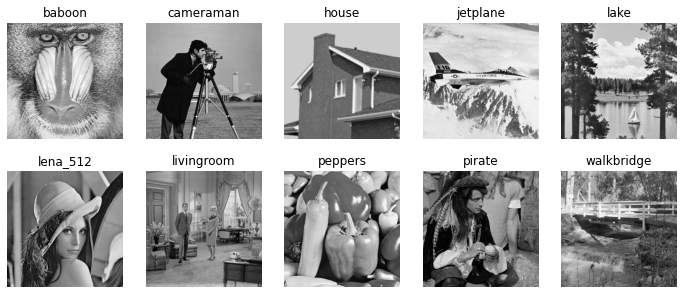

In [3]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [4]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])

In [5]:
dataset.shape

(10, 512, 512)

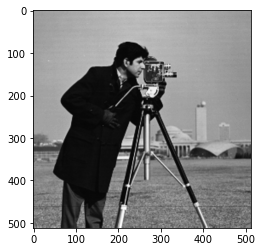

In [6]:
plt.imshow(dataset[1], cmap='gray')

In [7]:
d = 9
matrix_modes = [2] * d
original = dataset[1]
#original = original / 255.

vector, vector_modes = utils.matrix_to_vector(original, d, matrix_modes)

In [9]:
preproc = wrappers.RPCA_preprocessing_wrapper(2)
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=2.5,
    max_iter=100
)

In [10]:
ranks

[4, 16, 64, 256, 256, 64, 16, 4]

In [11]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

In [12]:
print(np.sum(np.isclose(original, low_rank_matrix)), original.size)

220882 262144


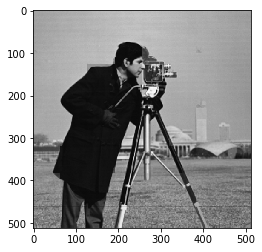

In [13]:
plt.imshow(low_rank_matrix, interpolation='nearest', cmap='gray')

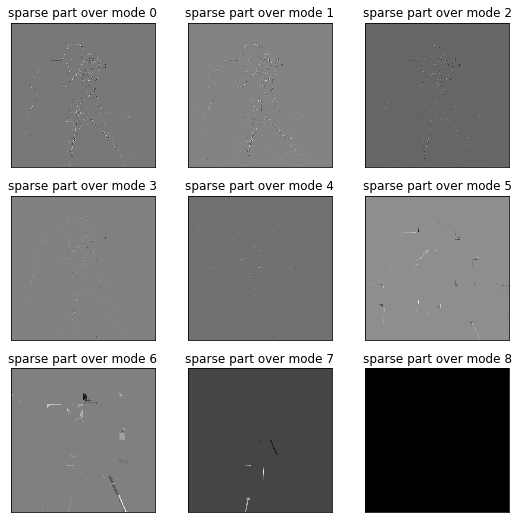

In [14]:
n = 2 ** d
sparse_to_show = []
for s in preproc.sparse_parts:
    sparse_to_show.append(
        utils.vector_to_matrix(
            s.toarray().flatten(order='F'),
            d,
            vector_modes
        )[0]
    )

fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        #sparse_parts[i].toarray(),
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))

In [15]:
sum_sparse = np.sum(sparse_to_show, axis=0)
print(np.linalg.norm(original - sum_sparse - low_rank_matrix) / np.linalg.norm(original))

1.7065698649768141e-06


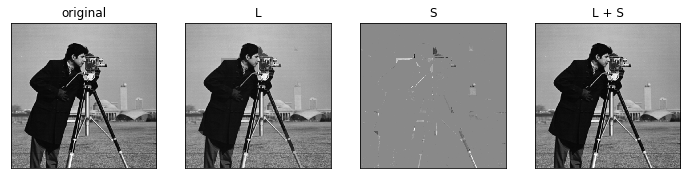

In [17]:
fig = plt.figure(figsize=(12, 3))
data_to_show = [original, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'L', 'S', 'L + S']
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Попробуем потестировать на salt-and-pepper noise, что ли...

In [18]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
#вообще, наверное, есть более-менее строгое определение, но я его не нашёл

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

$$p \in [0,1/2] \Rightarrow \hat{A}_{ij} = \begin{cases}
0 &\text{с вероятностью $p$} \\
255 &\text{с вероятностью $p$} \\
A_{ij} &\text{с вероятностью $1 - 2p$} \\
\end{cases}$$
Броски независимые для разных $i,j$.

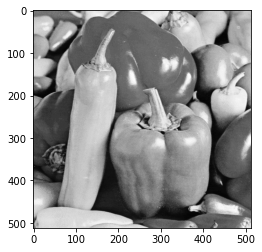

In [19]:
original = dataset[7]
plt.imshow(original, cmap='gray')

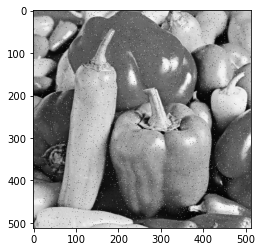

In [20]:
noisy = sp_noise(original, 0.01)
plt.imshow(noisy, cmap='gray')

Пошёл пайплайн:

In [21]:
vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=2.,
    max_iter=200
)

In [22]:
ranks

[4, 16, 64, 256, 256, 64, 16, 4]

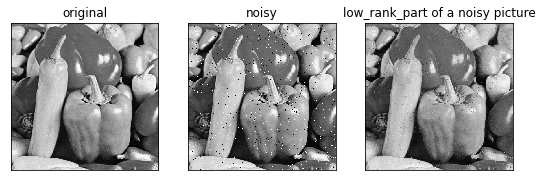

In [23]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

fig = plt.figure(figsize=(9, 3))
data_to_show = [original, noisy, low_rank_matrix]
data_labels = ['original', 'noisy', 'low_rank_part of a noisy picture']
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Сложим разреженные части:

In [26]:
sparse_to_show = []
for s in preproc.sparse_parts:
    sparse_to_show.append(
        utils.vector_to_matrix(
            s.toarray().flatten(order='F'),
            d,
            vector_modes
        )[0]
    )
sum_sparse = np.sum(sparse_to_show, axis=0)

In [27]:
#тест метода
tmp = preproc.add_sparse_parts(low_rank_part)
tmp = utils.vector_to_matrix(tmp, d, vector_modes)[0]
print(np.linalg.norm(tmp - low_rank_matrix - sum_sparse))

3.920188565001997e-13


Нарисуем разреженные части теперь:

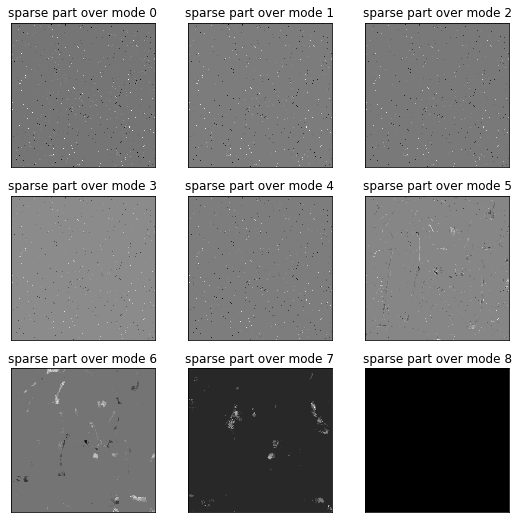

In [28]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Правда ли, что low_rank_part ближе к оригинальному изображению, нежели к шуму? 

In [29]:
print(np.linalg.norm(low_rank_matrix - noisy) / np.linalg.norm(original))
print(np.linalg.norm(low_rank_matrix - original) / np.linalg.norm(original))

0.10482223178304301
0.07200009106387543


Ненамного, но да, ближе.

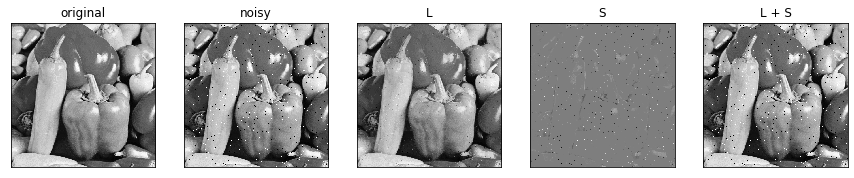

In [30]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Протестируем верхнее жёсткое ограничение на ранг:

In [50]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    upper_ranks=[20] * (d - 1),
    lambda_scale=3.,
    max_iter=400
)

In [51]:
ranks

[4, 16, 20, 20, 20, 20, 16, 4]

In [52]:
low_rank_part

array([129.28499184, 129.29542373, 127.5529875 , ..., 207.65890669,
       207.0624603 , 207.75007027])

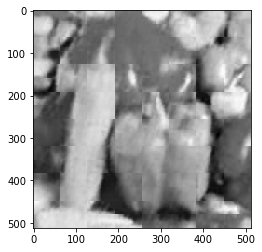

In [53]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
plt.imshow(low_rank_matrix, interpolation="nearest", cmap='gray')

Как будто покорёжено, но шума с виду меньше.

In [54]:
sparse_to_show = []
for s in preproc.sparse_parts:
    sparse_to_show.append(
        utils.vector_to_matrix(
            s.toarray().flatten(order='F'),
            d,
            vector_modes
        )[0]
    )
sum_sparse = np.sum(sparse_to_show, axis=0)

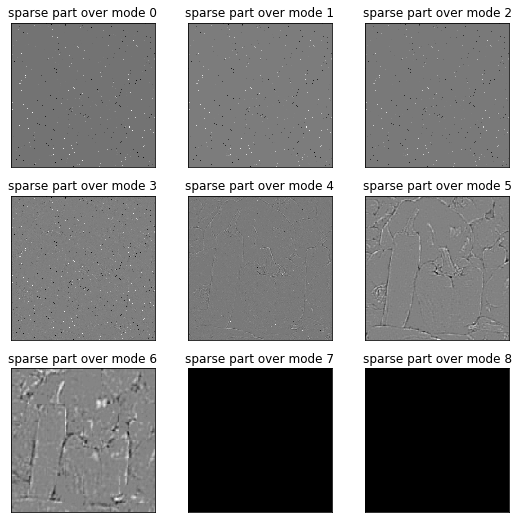

In [55]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Всё же деталей в sparse-части теперь много уходит...

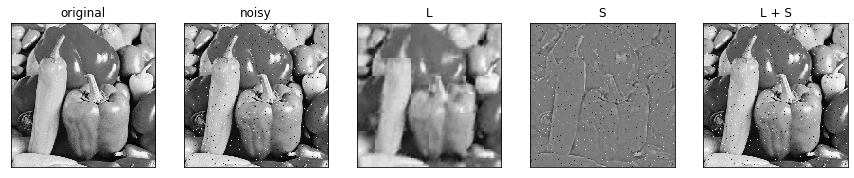

In [56]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

In [61]:
wtt = wrappers.WTTwrapper(1)
wtt.adjust(low_rank_part, d, vector_modes, ranks=ranks)
wtt.ranks

[4, 16, 20, 20, 20, 20, 16, 4]

In [62]:
wtt_res = wtt.apply(low_rank_part)
np.max(np.abs(wtt_res[1:]))

1.2927508950924905e-11

Мы затребовали маленькие ранги, так что неудивительно...

In [63]:
wtt_res[1:] = 0.
iwtt_res = wtt.apply_inverse(wtt_res)
iwtt_res = utils.vector_to_matrix(iwtt_res, d, vector_modes)[0]

iwtt_res

array([[129.28499184, 127.5529875 , 125.36555902, ..., 195.92850408,
        194.797866  , 194.22503957],
       [129.29542373, 127.57713012, 124.62973822, ..., 196.11811896,
        194.71342483, 193.53929807],
       [129.34945337, 127.03981519, 123.93800603, ..., 195.57467061,
        193.71372823, 193.09246452],
       ...,
       [133.23019075, 133.88823042, 135.86530013, ..., 204.47972355,
        205.51516842, 205.97406939],
       [133.59071041, 134.19509364, 136.1159086 , ..., 206.0877293 ,
        206.56270844, 207.0624603 ],
       [134.02389329, 135.42775768, 136.92415227, ..., 207.39898073,
        207.65890669, 207.75007027]])

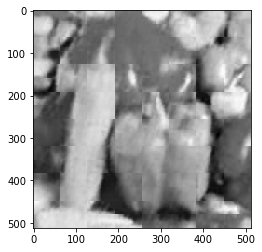

In [65]:
plt.imshow(iwtt_res, interpolation='nearest', cmap='gray')